In [1]:
# import libraries I foresee using

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# to process breast_cancer_diagnosis_desc column
from preprocess_text import MedicalTermsCleaner
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# for preprocessing 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler # chose this because less sensitive to extreme outliers 
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# regression models to test
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import SGDRegressor # checking that linear models aren't the best option given over 100 features
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# for putting everything together 
from sklearn.pipeline import Pipeline

# for metrics
from sklearn.metrics import mean_squared_error

# for machine learning visualization
from yellowbrick.target import FeatureCorrelation

In [3]:
pd.set_option('display.max_columns', None)

In [5]:
# load data 
data = pd.read_csv('train.csv')
data.head()

,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period
0,268700,NaN,COMMERCIAL,AR,724,South,West South Central,39,F,NaN,C50912,Malignant neoplasm of unspecified site of left...,C773,NaN,NaN,3924.87,82.63,42.58,11.61,13.03,10.87,11.80,12.29,13.22,13.47,10.07,3.64,51.43,48.57,51.05,16.72,23.57,8.66,3.01,43.99,44483.35,2.21,3.97,8.52,7.08,7.67,13.82,15.14,17.51,11.26,8.90,3.93,12.83,24048.55,72.11,1513.75,87384.33,641.39,27.52,16.55,41.83,28.31,9.21,4.11,13.32,38.78,53.60,5.85,11.82,5.31,92.95,1.73,0.33,0.20,0.03,0.83,3.94,3.03,22.24,19.27,0.42,25.35,8.06,8.11,38.55,39.88,42.75,55.16,65.17,75.98,76.75,76.45,73.67,59.73,45.18,37.43,31.67,33.83,42.35,57.72,67.35,75.92,74.28,79.59,70.84,62.39,41.89,41.46,35.24,31.10,45.50,60.94,68.49,77.69,81.35,76.28,73.32,60.32,51.00,48.37,35.76,42.89,53.21,61.07,66.29,82.78,81.52,79.52,75.61,65.76,53.85,39.56,41.59,49.01,52.28,63.40,67.11,75.78,80.58,76.16,72.91,62.68,49.73,39.80,31.71,41.69,50.22,52.55,74.77,79.96,81.69,78.30,74.56,59.98,42.98,41.18,191
1,484983,White,NaN,IL,629,Midwest,East North Central,55,F,35.36,C50412,Malig neoplasm of upper-outer quadrant of left...,C773,NaN,NaN,2745.39,51.79,43.54,11.22,12.19,11.45,11.01,11.35,14.39,14.15,9.17,5.05,49.32,50.68,49.48,15.42,26.93,8.17,3.17,41.41,51796.79,3.67,3.86,6.58,5.58,5.38,11.02,13.09,19.56,11.76,11.40,8.11,19.51,28028.04,76.71,1113.35,92026.84,638.60,29.37,10.93,35.26,35.33,12.46,6.04,18.49,36.35,52.51,7.45,9.19,5.21,88.75,6.44,0.

In [7]:
data.shape

(13173, 152)

In [9]:
data.describe()

,patient_id,patient_zip3,patient_age,bmi,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period
count,13173.000000,13173.000000,13173.000000,4102.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13168.000000,13168.000000,13168.000000,13168.000000,13168.000000,13168.000000,13168.000000,13168.000000,13168.000000,13168.000000,13168.000000,13168.000000,13168.000000,13168.000000,13168.000000,13173.000000,13168.000000,13173.000000,1.316800e+04,13168.000000,13168.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13168.000000,13168.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13168.000000,13168.000000,13173.000000,13173.000000,13173.000000,13140.000000,13170.000000,13173.000000,13173.000000,13170.000000,13153.000000,13173.000000,13156.000000,13146.000000,13114.000000,13170.000000,13170.000000,13169.000000,13164.000000,13144.000000,12993.000000,13173.000000,13021.000000,13173.000000,13173.000000,13173.000000,13173.000000,13149.000000,13173.000000,13167.000000,13161.000000,13161.00000,13145.000000,13173.000000,13173.000000,13173.000000,13151.000000,13173.000000,13157.000000,13157.000000,13155.000000,13157.000000,13157.000000,13173.000000,13173.000000,13154.000000,13173.000000,13157.000000,13173.000000,13173.000000,13173.000000,13170.000000,13160.000000,13164.000000,13173.000000,13173.000000,13173.000000,13173.000000,13172.000000,13142.000000,13173.000000,13163.0

In [11]:
# columns with missing values 
missing = data.isna().sum().reset_index()
missing = missing.rename(columns={0:'count_na'})
missing.head()

,index,count_na
0,patient_id,0
1,patient_race,6657
2,payer_type,1765
3,patient_state,0
4,patient_zip3,0


In [13]:
missing_counts = dict()

for idx, row in missing.iterrows():
    feature = row['index']
    if row['count_na'] > 0:
        missing_counts[feature] = row['count_na']

In [15]:
missing_counts

{'patient_race': 6657,
 'payer_type': 1765,
 'bmi': 9071,
 'metastatic_first_novel_treatment': 13162,
 'metastatic_first_novel_treatment_type': 13162,
 'family_size': 5,
 'family_dual_income': 5,
 'income_household_median': 5,
 'income_household_under_5': 5,
 'income_household_5_to_10': 5,
 'income_household_10_to_15': 5,
 'income_household_15_to_20': 5,
 'income_household_20_to_25': 5,
 'income_household_25_to_35': 5,
 'income_household_35_to_50': 5,
 'income_household_50_to_75': 5,
 'income_household_75_to_100': 5,
 'income_household_100_to_150': 5,
 'income_household_150_over': 5,
 'income_household_six_figure': 5,
 'home_ownership': 5,
 'home_value': 5,
 'rent_median': 5,
 'rent_burden': 5,
 'self_employed': 5,
 'farmer': 5,
 'poverty': 5,
 'limited_english': 5,
 'Average of Jan-13': 33,
 'Average of Feb-13': 3,
 'Average of May-13': 3,
 'Average of Jun-13': 20,
 'Average of Aug-13': 17,
 'Average of Sep-13': 27,
 'Average of Oct-13': 59,
 'Average of Nov-13': 3,
 'Average of Dec-1

In [17]:
# get rid of columns where the majority of values are missing 
drop_cols = ['patient_race', 'bmi', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type']

data.drop(columns=drop_cols, axis=1, inplace=True)
data.head()

,patient_id,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period
0,268700,COMMERCIAL,AR,724,South,West South Central,39,F,C50912,Malignant neoplasm of unspecified site of left...,C773,3924.87,82.63,42.58,11.61,13.03,10.87,11.80,12.29,13.22,13.47,10.07,3.64,51.43,48.57,51.05,16.72,23.57,8.66,3.01,43.99,44483.35,2.21,3.97,8.52,7.08,7.67,13.82,15.14,17.51,11.26,8.90,3.93,12.83,24048.55,72.11,1513.75,87384.33,641.39,27.52,16.55,41.83,28.31,9.21,4.11,13.32,38.78,53.60,5.85,11.82,5.31,92.95,1.73,0.33,0.20,0.03,0.83,3.94,3.03,22.24,19.27,0.42,25.35,8.06,8.11,38.55,39.88,42.75,55.16,65.17,75.98,76.75,76.45,73.67,59.73,45.18,37.43,31.67,33.83,42.35,57.72,67.35,75.92,74.28,79.59,70.84,62.39,41.89,41.46,35.24,31.10,45.50,60.94,68.49,77.69,81.35,76.28,73.32,60.32,51.00,48.37,35.76,42.89,53.21,61.07,66.29,82.78,81.52,79.52,75.61,65.76,53.85,39.56,41.59,49.01,52.28,63.40,67.11,75.78,80.58,76.16,72.91,62.68,49.73,39.80,31.71,41.69,50.22,52.55,74.77,79.96,81.69,78.30,74.56,59.98,42.98,41.18,191
1,484983,NaN,IL,629,Midwest,East North Central,55,F,C50412,Malig neoplasm of upper-outer quadrant of left...,C773,2745.39,51.79,43.54,11.22,12.19,11.45,11.01,11.35,14.39,14.15,9.17,5.05,49.32,50.68,49.48,15.42,26.93,8.17,3.17,41.41,51796.79,3.67,3.86,6.58,5.58,5.38,11.02,13.09,19.56,11.76,11.40,8.11,19.51,28028.04,76.71,1113.35,92026.84,638.60,29.37,10.93,35.26,35.33,12.46,6.04,18.49,36.35,52.51,7.45,9.19,5.21,88.75,6.44,0.53,0.19,0.05,0.61,3.42,2.78,20.16,16.94,0.43,26.26,6.93,9.71,34.85,36.15,39.41,54.63,65.41,73.89,74.07,74.37,70.44,57.37,42.

In [19]:
# curious if the rows with missing values for demographic data are the same 5 rows 

missing_demo = data[data['family_size'].isna()]
missing_demo

,patient_id,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period
3985,757384,COMMERCIAL,TX,772,South,West South Central,43,F,C50911,Malignant neoplasm of unsp site of right femal...,C773,4459.0,3376.1,20.6,0.0,35.3,62.1,1.5,0.8,0.0,0.2,0.0,0.0,47.1,52.9,0.9,0.2,98.9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4316.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,44.8,41.7,13.5,55.2,73.0,30.7,18.8,NaN,NaN,47.6,23.0,20.1,0.0,0.0,1.7,7.6,18.2,4.6,NaN,NaN,16.2,4.5,1.6,52.36,56.4,59.25,66.05,73.87,82.56,82.95,84.99,81.4,70.52,56.23,49.51,47.31,53.35,57.7,67.66,73.92,84.1,82.81,83.57,79.69,71.54,56.36,55.84,49.87,51.02,59.94,71.24,74.85,80.84,85.18,84.81,80.69,73.54,62.15,58.43,51.56,58.81,64.94,69.85,75.39,82.04,87.24,83.8,82.73,75.83,67.04,56.38,58.15,65.85,67.7,71.45,75.51,81.86,85.63,83.71,79.54,70.17,65.8,51.79,46.29,57.91,66.5,65.66,79.57,84.9,85.55,85.06,80.93,71.28,56.46,53.85,40
4404,367375,COMMERCIAL,TX,772,South,West South Central,61,F,1743,Malignant neoplasm of lower-inner quadrant of ...,C7951,4459.0,3376.1,20.6,0.0,35.3,62.1,1.5,0.8,0.0,0.2,0.0,0.0,47.1,52.9,0.9,0.2,98.9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4316.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,44.8,41.7,13.5,55.2,73.0,30.7,18.8,NaN,NaN,47.6,23.0,20.1,0.0,0.0,1.7,7.6,18.2,4.6,NaN,NaN,16.2,4.5,1.6,52.36,56.4,59.25,66.05,73.87,82.56,82.95,84.99,81.4,70.52,56.23,49.51,47.31,53.35,57.7,67.66,73.92,84.1,82.81,83.57,79.69,71.54,56.36,55.84,49.87,51.02,59.94,71.24,74.85,80.84,85.18,84.81,80.69,73.54,62.15,58.43,51.56,58.81,64.94,69.85,75.39,82.

In [21]:
# interesting, it's all for patient_zip3 == 772 
# are there other patients with zip3 == 772? if so, we can just fill the NaNs for this row with the same info

data_772 = data[data['patient_zip3']==772]
data_772.head()

,patient_id,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period
3985,757384,COMMERCIAL,TX,772,South,West South Central,43,F,C50911,Malignant neoplasm of unsp site of right femal...,C773,4459.0,3376.1,20.6,0.0,35.3,62.1,1.5,0.8,0.0,0.2,0.0,0.0,47.1,52.9,0.9,0.2,98.9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4316.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,44.8,41.7,13.5,55.2,73.0,30.7,18.8,NaN,NaN,47.6,23.0,20.1,0.0,0.0,1.7,7.6,18.2,4.6,NaN,NaN,16.2,4.5,1.6,52.36,56.4,59.25,66.05,73.87,82.56,82.95,84.99,81.4,70.52,56.23,49.51,47.31,53.35,57.7,67.66,73.92,84.1,82.81,83.57,79.69,71.54,56.36,55.84,49.87,51.02,59.94,71.24,74.85,80.84,85.18,84.81,80.69,73.54,62.15,58.43,51.56,58.81,64.94,69.85,75.39,82.04,87.24,83.8,82.73,75.83,67.04,56.38,58.15,65.85,67.7,71.45,75.51,81.86,85.63,83.71,79.54,70.17,65.8,51.79,46.29,57.91,66.5,65.66,79.57,84.9,85.55,85.06,80.93,71.28,56.46,53.85,40
4404,367375,COMMERCIAL,TX,772,South,West South Central,61,F,1743,Malignant neoplasm of lower-inner quadrant of ...,C7951,4459.0,3376.1,20.6,0.0,35.3,62.1,1.5,0.8,0.0,0.2,0.0,0.0,47.1,52.9,0.9,0.2,98.9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4316.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,44.8,41.7,13.5,55.2,73.0,30.7,18.8,NaN,NaN,47.6,23.0,20.1,0.0,0.0,1.7,7.6,18.2,4.6,NaN,NaN,16.2,4.5,1.6,52.36,56.4,59.25,66.05,73.87,82.56,82.95,84.99,81.4,70.52,56.23,49.51,47.31,53.35,57.7,67.66,73.92,84.1,82.81,83.57,79.69,71.54,56.36,55.84,49.87,51.02,59.94,71.24,74.85,80.84,85.18,84.81,80.69,73.54,62.15,58.43,51.56,58.81,64.94,69.85,75.39,82.

In [23]:
data_772.shape

(5, 148)

In [25]:
# however, 772 is for Houston, and 770 is also for Houston, so maybe we can use this zip3 to fill in the NAs instead?

data_770 = data[data['patient_zip3']==770]
data_770.shape

(121, 148)

In [63]:
data_770.head()

,patient_id,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period
24,752174,MEDICARE ADVANTAGE,TX,770,South,West South Central,77,F,C50919,Malignant neoplasm of unsp site of unspecified...,C773,33353.72,1836.73,34.71,13.51,13.54,15.52,15.84,12.8,11.74,9.7,5.05,2.28,49.98,50.02,42.93,12.65,39.89,4.53,3.39,51.24,66076.27,4.08,3.09,4.35,4.47,4.71,10.18,12.72,17.11,10.93,12.79,15.56,28.36,37965.46,49.7,12096.22,247842.7,1193.59,32.92,21.3,22.5,23.68,19.41,13.1,32.51,47.45,66.17,6.71,17.26,0.27,47.42,22.5,7.07,0.52,0.04,11.34,11.12,44.48,9.89,18.73,13.97,27.93,22.54,3.77,53.62,57.57,60.04,65.86,74.01,82.82,83.19,84.39,81.61,71.29,57.74,50.59,48.54,54.11,58.25,68.19,73.46,83.03,82.81,83.96,79.68,72.08,57.28,56.25,49.87,51.89,61.35,71.9,76.12,81.3,85.22,84.29,79.9,73.49,63.61,59.46,51.92,58.94,65.89,69.98,75.39,82.04,86.22,83.8,82.57,75.58,67.2,58.23,59.44,65.98,67.99,71.59,75.64,81.66,85.04,83.61,79.6,71.53,66.63,53.12,47.43,61.48,66.91,66.5,79.54,84.57,84.85,85.09,80.61,72.46,58.14,55.77,118
82,465345,COMMERCIAL,TX,770,South,West South Central,64,F,1749,"Malignant neoplasm of breast (female), unspeci...",C7951,33353.72,1836.73,34.71,13.51,13.54,15.52,15.84,12.8,11.74,9.7,5.05,2.28,49.98,50.02,42.93,12.65,39.89,4.53,3.39,51.24,66076.27,4.08,3.09,4.35,4.47,4.71,10.18,12.72,17.11,10.93,12.79,15.56,28.36,37965.46,49.7,12096.22,247842.7,1193.59,32.92,21.3,22.5,23.68,19.41,13.1,32.51,47.45,66.17,6.71,17.26,0.27,47.42,22.5,7.07,0.52,0.04,11.34,11.12,44.48,9.89,18.73,13.97,27.93,22.54,3.77,53.62,57.57,60.04,65.86,74.01,82.82,83.19,84

In [27]:
# ok this is a possibility 
# there's also just this one zip3 that is weird *in this particular regard* 
# I don't necessarily want to go find the zip3 level data from the US Census Bureau
# to be continued 

### Visualizations with Yellowbrick: Feature Correlations 

In [29]:
# as a simple example, let's look at temperatures vs. metastatic_diagnosis_period
# for later, can also add a column for the same month between the years, e.g., (avg temp Jan 2018) - (avg temp Jan 13)
# this might be more useful, e.g., will let you know which areas are getting warmer (and potentially at a faster rate)

# first, figure out the relevant column indices
data.shape

(13173, 148)

In [31]:
# we have 72 columns of temperature data
# the last column (147) should be the metastatic_diagnosis_period 

data_last2 = data.iloc[:, 146:148] # slice is not inclusive of the end index, good to know 
data_last2.head()

,Average of Dec-18,metastatic_diagnosis_period
0,41.18,191
1,39.71,33
2,55.58,157
3,59.46,146
4,54.08,286


In [33]:
data_first2 = data.iloc[:, 75:77] # expect this to be Jan-13 and Feb-13
data_first2.head()

,Average of Jan-13,Average of Feb-13
0,38.55,39.88
1,34.85,36.15
2,53.14,55.28
3,57.88,57.65
4,51.08,52.29


In [39]:
data_temps = data.iloc[:, 75:]
data_temps.head()

,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period
0,38.55,39.88,42.75,55.16,65.17,75.98,76.75,76.45,73.67,59.73,45.18,37.43,31.67,33.83,42.35,57.72,67.35,75.92,74.28,79.59,70.84,62.39,41.89,41.46,35.24,31.10,45.50,60.94,68.49,77.69,81.35,76.28,73.32,60.32,51.00,48.37,35.76,42.89,53.21,61.07,66.29,82.78,81.52,79.52,75.61,65.76,53.85,39.56,41.59,49.01,52.28,63.40,67.11,75.78,80.58,76.16,72.91,62.68,49.73,39.80,31.71,41.69,50.22,52.55,74.77,79.96,81.69,78.30,74.56,59.98,42.98,41.18,191
1,34.85,36.15,39.41,54.63,65.41,73.89,74.07,74.37,70.44,57.37,42.15,33.16,26.88,28.36,40.32,56.85,66.84,75.12,72.18,77.08,67.15,58.34,38.55,38.54,32.33,25.62,43.52,58.50,66.81,75.41,78.43,73.88,70.78,58.70,50.50,46.71,32.36,38.76,51.68,58.41,64.10,78.15,79.70,78.33,72.80,63.84,50.35,34.90,39.05,45.80,48.45,60.77,65.89,74.46,79.18,73.13,70.13,59.68,46.52,35.15,28.43,40.01,44.18,49.30,72.87,77.40,77.43,75.83,72.64,58.36,39.68,39.71,33
2,53.14,55.28,64.75,67.38,73.31,79.49,84.01,83.28,79.88,67.84,61.92,55.69,60.56,60.99,65.16,68.01,74.24,78.87,84.65,82.23,81.75,74.25,63.29,56.28,58.32,62.97,67.61,67.39,68.06,80.43,80.98,85.08,82.01,75.16,59.59,53.24,54.54,63.52,63.72,67.45,69.58,82.02,84.83,84.06,77.85,72.50,64.24,55.52,53.54,58.18,65.45,68.51,71.13,80.71,85.64,84.85,78.14,74.03,65.70,59.28,60.34,57.43,60.97,68.50,70.31,78.61,87.24,85.52,80.75,70.81,62.67,55.58,157
3,57.88,57.65,60.86,62.77,67.07,68.41,70.69,71.19,72.74,66.41,65.09,60.87,64.30,60.77,63.01,64.37,69.73,68.46,73.62,73.65,75.96,71.83,67.04,59.73,63.27,63.83,67.72,64.39,62.56,69.66,72.21,77.47,76.77,74.50,63.48,57.98,57.69,66.53,61.89,64.86,62.63,70.45,73.09,71.94,72.26,69.56,66.85,58.29,56.08,57.88,63.84,65.03,63.90,68.95,73.58,73.62,72.88,73.84,68.87,66.63,63.75,59.89,59.35,63.34,63.10,67.45,75.86,75.24,71.10,68.95,65.46,59.46,146
4,51.08,52.29,58.31,60.43,63.65,67.41,68.21,67.95,67.95,61.73,58.04,53.04,58.12,55.83,58.73,59.53,64.20,64.02,68.84,68.18,67.29,67.08,59.49,54.23,55.19,57.03,63.73,60.69,58.19,65.61,67.79,69.57,71.37,68.40,55.45,49.49,54.15,60.98,58.44,62.06,61.68,70.15,69.49,66.71,68.10,64.41,59.72,52.52,51.80,54.20,59.36,60.44,62.41,67.57,71.29,70.83,69.43,65.56,59.60,54.21,57.70,53.60,55.78,59.45,60.24,64.77,69.81,70.13,68.10,65.38,60.72,54.08,286


In [43]:
data_temps.shape

(13173, 73)

In [45]:
data_temps_clean = data_temps.dropna()
data_temps_clean.shape

(12767, 73)

In [47]:
features = data_temps_clean.iloc[:, :72]
features.head()

,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18
0,38.55,39.88,42.75,55.16,65.17,75.98,76.75,76.45,73.67,59.73,45.18,37.43,31.67,33.83,42.35,57.72,67.35,75.92,74.28,79.59,70.84,62.39,41.89,41.46,35.24,31.10,45.50,60.94,68.49,77.69,81.35,76.28,73.32,60.32,51.00,48.37,35.76,42.89,53.21,61.07,66.29,82.78,81.52,79.52,75.61,65.76,53.85,39.56,41.59,49.01,52.28,63.40,67.11,75.78,80.58,76.16,72.91,62.68,49.73,39.80,31.71,41.69,50.22,52.55,74.77,79.96,81.69,78.30,74.56,59.98,42.98,41.18
1,34.85,36.15,39.41,54.63,65.41,73.89,74.07,74.37,70.44,57.37,42.15,33.16,26.88,28.36,40.32,56.85,66.84,75.12,72.18,77.08,67.15,58.34,38.55,38.54,32.33,25.62,43.52,58.50,66.81,75.41,78.43,73.88,70.78,58.70,50.50,46.71,32.36,38.76,51.68,58.41,64.10,78.15,79.70,78.33,72.80,63.84,50.35,34.90,39.05,45.80,48.45,60.77,65.89,74.46,79.18,73.13,70.13,59.68,46.52,35.15,28.43,40.01,44.18,49.30,72.87,77.40,77.43,75.83,72.64,58.36,39.68,39.71
2,53.14,55.28,64.75,67.38,73.31,79.49,84.01,83.28,79.88,67.84,61.92,55.69,60.56,60.99,65.16,68.01,74.24,78.87,84.65,82.23,81.75,74.25,63.29,56.28,58.32,62.97,67.61,67.39,68.06,80.43,80.98,85.08,82.01,75.16,59.59,53.24,54.54,63.52,63.72,67.45,69.58,82.02,84.83,84.06,77.85,72.50,64.24,55.52,53.54,58.18,65.45,68.51,71.13,80.71,85.64,84.85,78.14,74.03,65.70,59.28,60.34,57.43,60.97,68.50,70.31,78.61,87.24,85.52,80.75,70.81,62.67,55.58
3,57.88,57.65,60.86,62.77,67.07,68.41,70.69,71.19,72.74,66.41,65.09,60.87,64.30,60.77,63.01,64.37,69.73,68.46,73.62,73.65,75.96,71.83,67.04,59.73,63.27,63.83,67.72,64.39,62.56,69.66,72.21,77.47,76.77,74.50,63.48,57.98,57.69,66.53,61.89,64.86,62.63,70.45,73.09,71.94,72.26,69.56,66.85,58.29,56.08,57.88,63.84,65.03,63.90,68.95,73.58,73.62,72.88,73.84,68.87,66.63,63.75,59.89,59.35,63.34,63.10,67.45,75.86,75.24,71.10,68.95,65.46,59.46
4,51.08,52.29,58.31,60.43,63.65,67.41,68.21,67.95,67.95,61.73,58.04,53.04,58.12,55.83,58.73,59.53,64.20,64.02,68.84,68.18,67.29,67.08,59.49,54.23,55.19,57.03,63.73,60.69,58.19,65.61,67.79,69.57,71.37,68.40,55.45,49.49,54.15,60.98,58.44,62.06,61.68,70.15,69.49,66.71,68.10,64.41,59.72,52.52,51.80,54.20,59.36,60.44,62.41,67.57,71.29,70.83,69.43,65.56,59.60,54.21,57.70,53.60,55.78,59.45,60.24,64.77,69.81,70.13,68.10,65.38,60.72,54.08


In [49]:
y = data_temps_clean.iloc[:, 72]
y.head()

0    191
1     33
2    157
3    146
4    286
Name: metastatic_diagnosis_period, dtype: int64

In [51]:
labels_temps = np.array(features.columns)

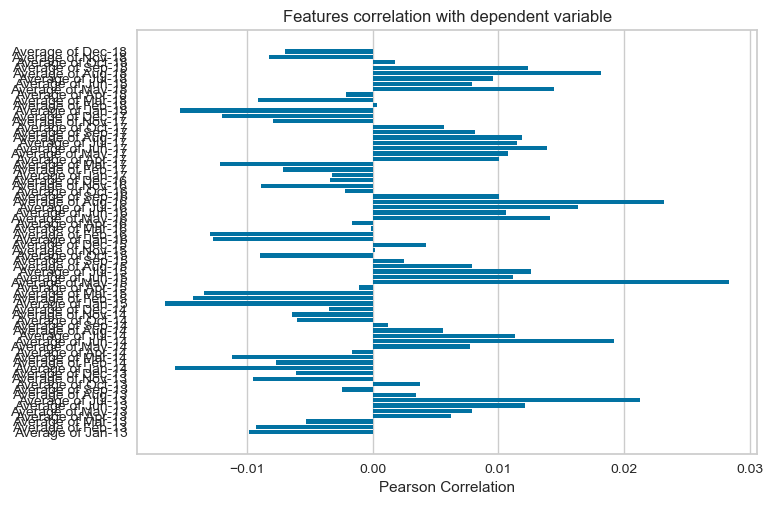

<Axes: title={'center': 'Features correlation with dependent variable'}, xlabel='Pearson Correlation'>

In [53]:
# yellowbrick visualizer 

visualizer = FeatureCorrelation(labels=labels_temps)

visualizer.fit(features, y) # Fit the data to the visualizer
visualizer.show() # Finalize and render the figure

In [57]:
# rename the temp columns 

for col in features.columns:
    features.rename(columns={col:col.replace("Average of ","")},inplace=True)

In [59]:
features.columns

Index(['Jan-13', 'Feb-13', 'Mar-13', 'Apr-13', 'May-13', 'Jun-13', 'Jul-13',
       'Aug-13', 'Sep-13', 'Oct-13', 'Nov-13', 'Dec-13', 'Jan-14', 'Feb-14',
       'Mar-14', 'Apr-14', 'May-14', 'Jun-14', 'Jul-14', 'Aug-14', 'Sep-14',
       'Oct-14', 'Nov-14', 'Dec-14', 'Jan-15', 'Feb-15', 'Mar-15', 'Apr-15',
       'May-15', 'Jun-15', 'Jul-15', 'Aug-15', 'Sep-15', 'Oct-15', 'Nov-15',
       'Dec-15', 'Jan-16', 'Feb-16', 'Mar-16', 'Apr-16', 'May-16', 'Jun-16',
       'Jul-16', 'Aug-16', 'Sep-16', 'Oct-16', 'Nov-16', 'Dec-16', 'Jan-17',
       'Feb-17', 'Mar-17', 'Apr-17', 'May-17', 'Jun-17', 'Jul-17', 'Aug-17',
       'Sep-17', 'Oct-17', 'Nov-17', 'Dec-17', 'Jan-18', 'Feb-18', 'Mar-18',
       'Apr-18', 'May-18', 'Jun-18', 'Jul-18', 'Aug-18', 'Sep-18', 'Oct-18',
       'Nov-18', 'Dec-18'],
      dtype='object')

In [79]:
t0 = ['Jan-13', 'Feb-13', 'Mar-13', 'Apr-13', 'May-13', 'Jun-13', 
      'Jul-13', 'Aug-13', 'Sep-13', 'Oct-13', 'Nov-13', 'Dec-13']

t1 = ['Jan-18', 'Feb-18', 'Mar-18', 'Apr-18', 'May-18', 'Jun-18',
      'Jul-18', 'Aug-18', 'Sep-18', 'Oct-18', 'Nov-18', 'Dec-18']

d_labels = []

for i, j in enumerate(t0):
    d = 'd_'+j[:3]
    d_labels.append(d)
    features[d] = features[t1[i]] - features[t0[i]]

In [81]:
features.head()

,Jan-13,Feb-13,Mar-13,Apr-13,May-13,Jun-13,Jul-13,Aug-13,Sep-13,Oct-13,Nov-13,Dec-13,Jan-14,Feb-14,Mar-14,Apr-14,May-14,Jun-14,Jul-14,Aug-14,Sep-14,Oct-14,Nov-14,Dec-14,Jan-15,Feb-15,Mar-15,Apr-15,May-15,Jun-15,Jul-15,Aug-15,Sep-15,Oct-15,Nov-15,Dec-15,Jan-16,Feb-16,Mar-16,Apr-16,May-16,Jun-16,Jul-16,Aug-16,Sep-16,Oct-16,Nov-16,Dec-16,Jan-17,Feb-17,Mar-17,Apr-17,May-17,Jun-17,Jul-17,Aug-17,Sep-17,Oct-17,Nov-17,Dec-17,Jan-18,Feb-18,Mar-18,Apr-18,May-18,Jun-18,Jul-18,Aug-18,Sep-18,Oct-18,Nov-18,Dec-18,d_Jan,d_Feb,d_Mar,d_Apr,d_May,d_Jun,d_Jul,d_Aug,d_Sep,d_Oct,d_Nov,d_Dec
0,38.55,39.88,42.75,55.16,65.17,75.98,76.75,76.45,73.67,59.73,45.18,37.43,31.67,33.83,42.35,57.72,67.35,75.92,74.28,79.59,70.84,62.39,41.89,41.46,35.24,31.10,45.50,60.94,68.49,77.69,81.35,76.28,73.32,60.32,51.00,48.37,35.76,42.89,53.21,61.07,66.29,82.78,81.52,79.52,75.61,65.76,53.85,39.56,41.59,49.01,52.28,63.40,67.11,75.78,80.58,76.16,72.91,62.68,49.73,39.80,31.71,41.69,50.22,52.55,74.77,79.96,81.69,78.30,74.56,59.98,42.98,41.18,-6.84,1.81,7.47,-2.61,9.60,3.98,4.94,1.85,0.89,0.25,-2.20,3.75
1,34.85,36.15,39.41,54.63,65.41,73.89,74.07,74.37,70.44,57.37,42.15,33.16,26.88,28.36,40.32,56.85,66.84,75.12,72.18,77.08,67.15,58.34,38.55,38.54,32.33,25.62,43.52,58.50,66.81,75.41,78.43,73.88,70.78,58.70,50.50,46.71,32.36,38.76,51.68,58.41,64.10,78.15,79.70,78.33,72.80,63.84,50.35,34.90,39.05,45.80,48.45,60.77,65.89,74.46,79.18,73.13,70.13,59.68,46.52,35.15,28.43,40.01,44.18,49.30,72.87,77.40,77.43,75.83,72.64,58.36,39.68,39.71,-6.42,3.86,4.77,-5.33,7.46,3.51,3.36,1.46,2.20,0.99,-2.47,6.55
2,53.14,55.28,64.75,67.38,73.31,79.49,84.01,83.28,79.88,67.84,61.92,55.69,60.56,60.99,65.16,68.01,74.24,78.87,84.65,82.23,81.75,74.25,63.29,56.28,58.32,62.97,67.61,67.39,68.06,80.43,80.98,85.08,82.01,75.16,59.59,53.24,54.54,63.52,63.72,67.45,69.58,82.02,84.83,84.06,77.85,72.50,64.24,55.52,53.54,58.18,65.45,68.51,71.13,80.71,85.64,84.85,78.14,74.03,65.70,59.28,60.34,57.43,60.97,68.50,70.31,78.61,87.24,85.52,80.75,70.81,62.67,55.58,7.20,2.15,-3.78,1.12,-3.00,-0.88,3.23,2.24,0.87,2.97,0.75,-0.11
3,57.88,57.65,60.86,62.77,67.07,68.41,70.69,71.19,72.74,66.41,65.09,60.87,64.30,60.77,63.01,64.37,69.73,68.46,73.62,73.65,75.96,71.83,67.04,59.73,63.27,63.83,67.72,64.39,62.56,69.66,72.21,77.47,76.77,74.50,63.48,57.98,57.69,66.53,61.89,64.86,62.63,70.45,73.09,71.94,72.26,69.56,66.85,58.29,56.08,57.88,63.84,65.03,63.90,68.95,73.58,73.62,72.88,73.84,68.87,66.63,63.75,59.89,59.35,63.34,63.10,67.45,75.86,75.24,71.10,68.95,65.46,59.46,5.87,2.24,-1.51,0.57,-3.97,-0.96,5.17,4.05,-1.64,2.54,0.37,-1.41
4,51.08,52.29,58.31,60.43,63.65,67.41,68.21,67.95,67.95,61.73,58.04,53.04,58.12,55.83,58.73,59.53,64.20,64.02,68.84,68.18,67.29,67.08,59.49,54.23,55.19,57.03,63.73,60.69,58.19,65.61,67.79,69.57,71.37,68.40,55.45,49.49,54.15,60.98,58.44,62.06,61.68,70.15,69.49,66.71,68.10,64.41,59.72,52.52,51.80,54.20,59.36,60.44,62.41,67.57,71.29,70.83,69.43,65.56,59.60,54.21,57.70,53.60,55.78,59.45,60.24,64.77,69.81,70.13,68.10,65.38,60.72,54.08,6.62,1.31,-2.53,-0.98,-3.41,-2.64,1.60,2.18,0.15,3.65,2.68,1.04


In [83]:
d_labels

['d_Jan',
 'd_Feb',
 'd_Mar',
 'd_Apr',
 'd_May',
 'd_Jun',
 'd_Jul',
 'd_Aug',
 'd_Sep',
 'd_Oct',
 'd_Nov',
 'd_Dec']

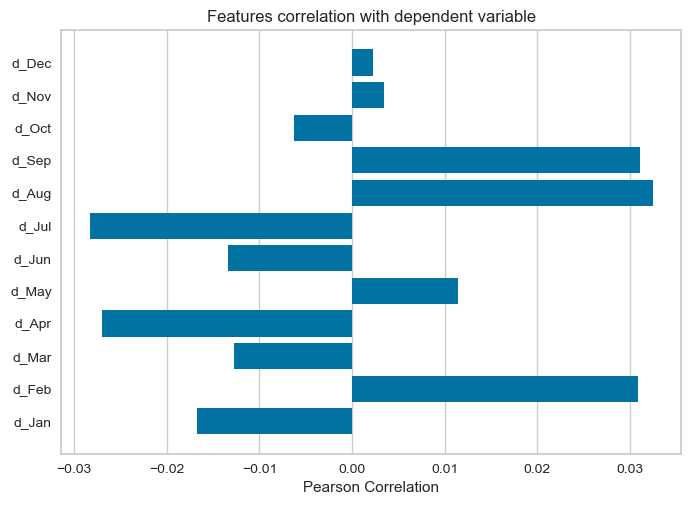

<Axes: title={'center': 'Features correlation with dependent variable'}, xlabel='Pearson Correlation'>

In [85]:
# let's look at just the 5-year difference of monthly averages
visualizer = FeatureCorrelation(labels=d_labels)

visualizer.fit(features.iloc[:,72:], y) # Fit the data to the visualizer
visualizer.show() # Finalize and render the figure

In [87]:
# these correlations are weak though, not even 0.05 

In [ ]:
# use yellowbrick to help with feature elimination 

from yellowbrick.model_selection import RFECV